In [43]:
import h5py
import numpy as np
import pandas as pd
import torch
import os
import glob
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [45]:
#['Large_Nuclear', 'CTCs', 'IM_CTC', 'PC_CTCs', 'Megakaryocytes', 'CECs', 'Large_Vimentin']


classes = {
    0: 'L-Nuclei',
    1: 'CTCs',
    2: 'imCTCs',
    3: 'pcCTCs',
    4: 'Mega-like',
    5: 'CECs',
    6: 'Fibro-like',
    7: 'Lymph',
    8: 'Gran',
    9: 'Mono'
    
}

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple',
		  'brown', 'pink', 'olive', 'gray', 'lightgray', 'yellow']

colors_dict = {k: c for k, c in zip(classes.values(), colors)}

In [46]:
# === Scientific Reports figure style ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update({
    "font.family":     "Helvetica",   # Sci Rep: single sans-serif family
    "font.size":        8,            # 8 pt everywhere after reduction
    "axes.labelsize":   8,
    "axes.titlesize":   8,
    "xtick.labelsize":  8,
    "ytick.labelsize":  8,
    "legend.fontsize":  8,
    "lines.linewidth":  0.6,          # ≥0.5 pt after final sizing
    "figure.dpi":       300,
})
sns.set_theme(context="paper", style="ticks", rc=mpl.rcParams)


In [47]:
def get_data_loaders(data_path, batch_size=64):
    types = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    images_list = []
    masks_list = []
    labels_list = []
    print(types)
    for label, t in enumerate(types):
        print(t)
        current_type_path = os.path.join(data_path, t)
        current_type_files = glob.glob(os.path.join(current_type_path, "*.hdf5"))
        class_images = []
        class_masks = []


        for file_path in current_type_files:
            with h5py.File(file_path, 'r') as f:
                imgs = np.array(f['images'][:])  # Ensure dtype matches the image data type
                msks = np.array(f['masks'][:])

                class_images.append(imgs)
                class_masks.append(msks)
                
        class_images = np.concatenate(class_images, axis=0)
        class_masks = np.concatenate(class_masks,axis=0)


        # (n, 75, 75, 1) for masks. if (n, 75, 75) then expand dims
        if len(class_masks.shape) == 3:
            class_masks = np.expand_dims(class_masks, axis=-1)
        
        #if mask > 0, then 1
        class_masks[class_masks > 0] = 1

        
        images_list.append(class_images)
        masks_list.append(class_masks)
        labels_list.append(np.full(len(class_images), label, dtype=np.int64))

    # Concatenate lists to form arrays
    
    images = np.concatenate(images_list, axis=0)
    masks = np.concatenate(masks_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    print(images.shape, masks.shape, labels.shape)

    return images, masks, labels

In [48]:
#data_path
dp = '/mnt/deepstore/LBxPheno/figures/figure2/data_dropped_NAN_CECs'
_, _, labels = get_data_loaders(dp, batch_size=512)

['Large_Nuclear', 'CTCs', 'IM_CTC', 'PC_CTCs', 'Megakaryocytes', 'CECs', 'Large_Vimentin']
Large_Nuclear
CTCs
IM_CTC
PC_CTCs
Megakaryocytes
CECs
Large_Vimentin
(2166, 75, 75, 4) (2166, 75, 75, 1) (2166,)


In [49]:
def load_traditional_wbcfeatures(path, img_idx=None):
    df = pd.read_csv(path, sep="\t")
    df["img_index"] = (
        df["image_name"].str.split("_").str[1].str.split(".").str[0].astype(int)
    )
    df = df.sort_values("img_index").reset_index(drop=True)
    if img_idx is not None:
        df = df.loc[img_idx].reset_index(drop=True)

    drop_starts = ("nucleusf.", "cellf.B")
    drop_ends   = (".cx", ".cy")
    drop_cont   = ("theta", "nucleus_cell_dist", "cell_nucleus_ratio", "tritc_cy5_ratio")

    keep = [
        c for c in df.columns
        if not c.startswith(drop_starts)
        and not c.endswith(drop_ends)
        and not any(x in c for x in drop_cont)
    ]
    
    return df[keep].drop(columns=["img_index", "image_name"])


In [50]:
def load_raretrad_features(path):
    df = pd.read_csv(path, sep="\t")
   
    drop_starts = ("nucleusf.", "cellf.B", "frame_id","cell_id","x","y","slide_id")
    drop_ends   = (".cx", ".cy")
    drop_cont   = ("theta", "nucleus_cell_dist", "cell_nucleus_ratio", "tritc_cy5_ratio")
    

    keep = [
        c for c in df.columns
        if not c.startswith(drop_starts)
        and not c.endswith(drop_ends)
        and not any(x in c for x in drop_cont)
    ]
    
    return df[keep].drop(columns=["image_name"])

In [51]:
with h5py.File('/mnt/deepstore/LBxPheno/figures/figure3/data/0ADD705_gated_full_final.hdf5', 'r') as f:
   raw_wbcimages = f['padded_images'][:]
   raw_wbcmasks = f['masks'][:]
raw_features = pd.read_hdf('/mnt/deepstore/LBxPheno/figures/figure3/data/0ADD705_gated_full_final.hdf5', 'features')

# sample n_sample of each group in features
raw_features['Multiclass_3'] = raw_features['Multiclass_5'].map({
	'Granulocytes': 'Granulocytes',
	'T-cells': 'Lymphocytes',
	'Monocyte/Macrophages': 'Monocyte/Macrophages',
	'B-cells': 'Lymphocytes',
	'NK-cells': 'Lymphocytes'
})

In [52]:
indices = []
for i in range(len(raw_wbcmasks)):
    if np.sum(raw_wbcmasks[i]) == 0:
        indices.append(i)

#delete the images and masks that have a mask that is entirely 0 pixels
raw_wbcimages = np.delete(raw_wbcimages, indices, axis=0)
raw_wbcimages = np.delete(raw_wbcimages, indices, axis=0)

#delete the corresponding rows in the features
raw_features = raw_features.drop(raw_features.index[indices])

#set all non-zero pixels in the mask to 1
raw_wbcmasks[raw_wbcmasks > 0] = 1

wbclabels = raw_features['Multiclass_5'].values
wbclabels[wbclabels == 'Granulocytes'] = 7
wbclabels[wbclabels == 'T-cells'] = 8
wbclabels[wbclabels == 'Monocyte/Macrophages'] = 9
wbclabels[wbclabels == 'B-cells'] = 8#10
wbclabels[wbclabels == 'NK-cells'] = 8#1

In [53]:
LABEL_MAP = {
    "Granulocytes": 7,
    "T-cells": 8,
    "Monocyte/Macrophages": 9,
    "B-cells": 8,    # 10 collapsed into 8
    "NK-cells": 8,   # 11 collapsed into 8
}

# where the two CellProfiler feature tables live
TRAD_PATHS = [
    "/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/eng_figure2/blurred_sigma_0.0_trad_feat.txt",
    "/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/eng_figure2/features.txt",
]


In [54]:
rare_cells = load_raretrad_features(TRAD_PATHS[0])
wbcells = load_traditional_wbcfeatures(TRAD_PATHS[1])

In [55]:
print(rare_cells.shape, wbcells.shape)

(2166, 368) (30059, 368)


In [56]:
wbclabels = wbclabels.astype(int)

In [57]:
#for rare cells, reorder the data to match a new set of labels
old_classes = classes = {
    0: 'L-Nuclei',
    1: 'CTCs',
    2: 'imCTCs',
    3: 'pcCTCs',
    4: 'Mega-like',
    5: 'CECs',
    6: 'Fibro-like',
    7: 'Lymph',
    8: 'Gran',
    9: 'Mono'
    
}

new_classes = {
    0: 'L-Nuclei',
    1: 'imCTCs',
    2: 'CTCs',
    3: 'pcCTCs',
    4: 'CECs',
    5: 'Mega-like',
    6: 'Fibro-like',
    7: 'Lymph',
    8: 'Gran',
    9: 'Mono'
    
}

rare_cells['label'] = labels



In [58]:
# --- build an old‑id → new‑id remapping --------------------------------------
name2new_id = {name: new_id for new_id, name in new_classes.items()}

remap = {old_id: name2new_id[name]       # e.g. 1 → 2, 2 → 1, 4 → 5, 5 → 4
         for old_id, name in old_classes.items()}

# ----------------------------------------------------------------------------- 
# 1) relabel the rows
rare_cells['label'] = rare_cells['label'].map(remap)

# 2) (optional) resort the frame so rows now appear in numeric order
rare_cells = rare_cells.sort_values('label').reset_index(drop=True)

In [60]:
print(rare_cells['label'].value_counts())

1    702
0    569
2    321
4    210
3    181
6    112
5     71
Name: label, dtype: int64


In [61]:
#drop the label column
labels = rare_cells['label']
rare_cells = rare_cells.drop(columns=['label'])

In [62]:
#downsample the wbcimages and masks to 500 for each class (7, 8, 9)
#find the unique labels
unique_labels = np.unique(wbclabels)
#downsample the images and masks to 500 for each class

downsampled_labels = []
downsampled_features = []

for label in unique_labels:
    #find the indices of the images that have the current label
    indices = np.where(wbclabels == label)[0]
    
    #if there are more than 500 images, then downsample to 500
    if len(indices) > 500:
        indices = np.random.choice(indices, 500, replace=False)

    downsampled_labels.append(wbclabels[indices])
    downsampled_features.append(wbcells.iloc[indices])
#concatenate the downsampled lists to form arrays

downsampled_labels = np.concatenate(downsampled_labels, axis=0)
downsampled_features = pd.concat(downsampled_features, axis=0)



In [63]:
labels = np.concatenate([labels, downsampled_labels], axis=0)
features = pd.concat([rare_cells, downsampled_features], axis=0)

In [64]:
print(labels.shape, features.shape)

(3666,) (3666, 368)


In [65]:
#scale the embeddings with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [66]:
import umap


reducer = umap.UMAP(n_neighbors=20, min_dist=0.4, metric='cosine', random_state=42)
embedding_umap = reducer.fit_transform(features)  
df_data = pd.DataFrame(embedding_umap, columns=['UMAP1', 'UMAP2'])
df_data['label'] = [list(new_classes.values())[l] for l in labels]

   

/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [67]:
colors_dict = {k: c for k, c in zip(new_classes.values(), colors)}

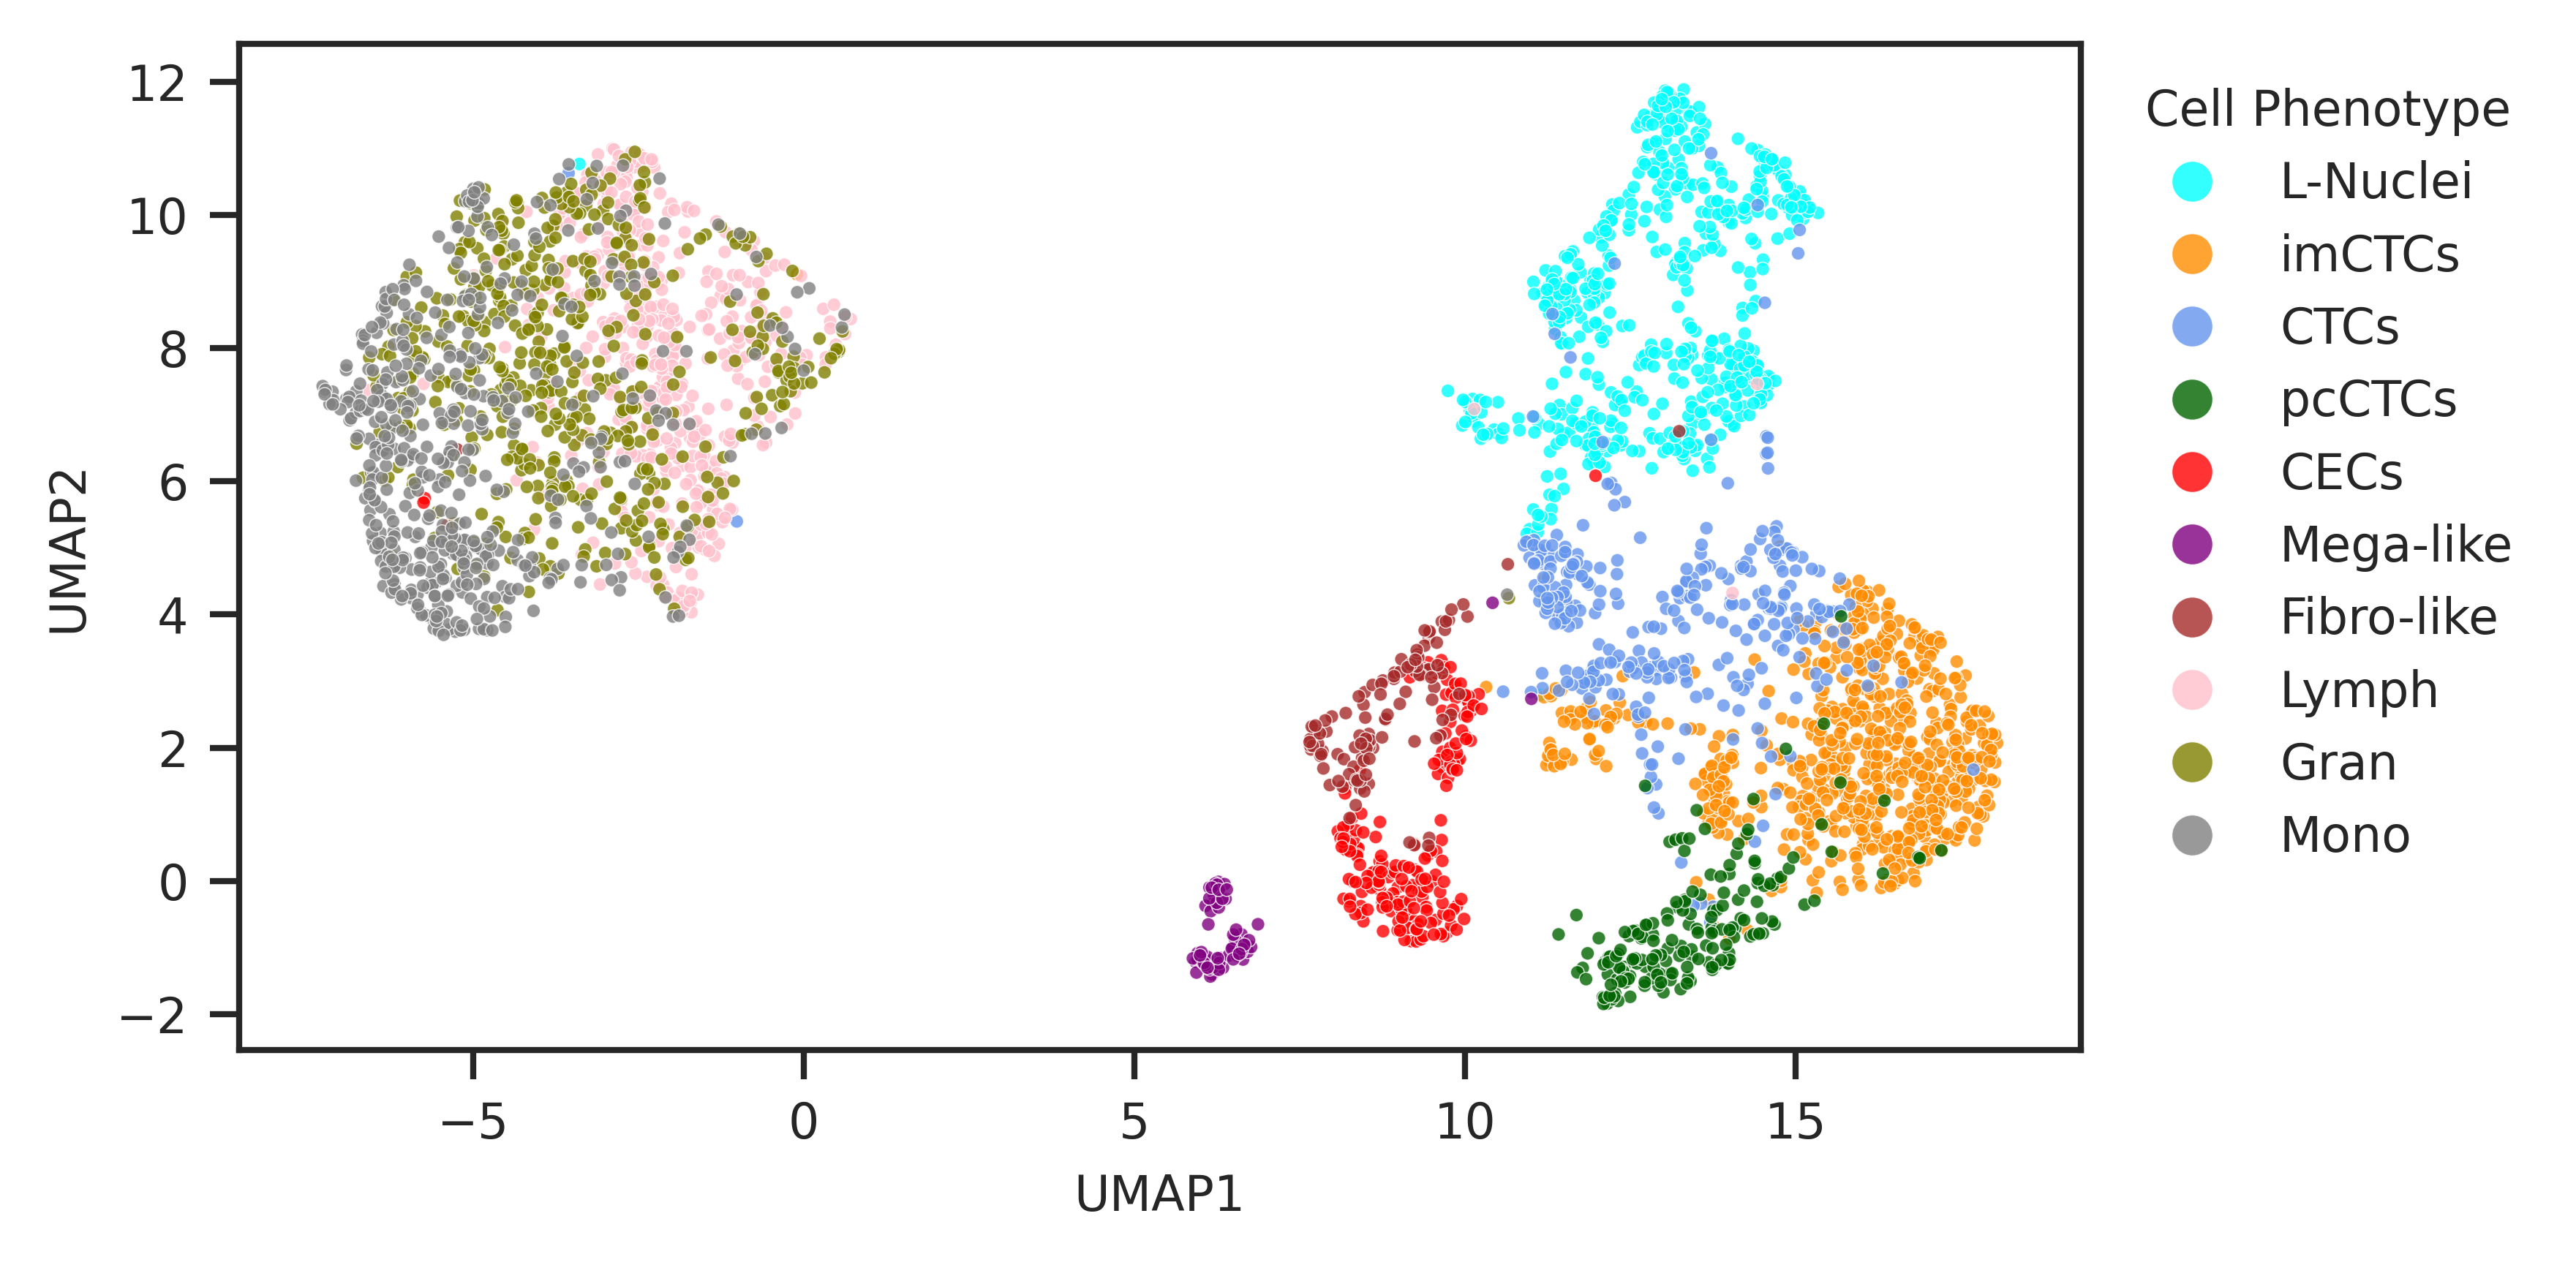

In [68]:
plt.figure(figsize=(6, 3), dpi=600)
sns.scatterplot(data=df_data,
	x='UMAP1', y='UMAP2', hue='label', palette=colors_dict, s=5, alpha=0.8)

# plt.scatter(embedding[:, 0], embedding[:, 1], c=label_colors, s=1)
plt.legend(title='Cell Phenotype', bbox_to_anchor=(1.01, 1), frameon=False, markerscale=3, fontsize=8, title_fontsize=8)
#save figure as 6.5 x 2 inches, 600 dpi
plt.tight_layout()
#set x label size to 8
plt.xlabel('UMAP1', fontsize=8)
#set y label size to 8
plt.ylabel('UMAP2', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
#remove the top and right spines
plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/eng_figure2/trad_umap.pdf',bbox_inches='tight',  dpi=600)
plt.show()

In [69]:
#split data 80/20 for training and testing
np.random.seed(1)  


random_indices = np.random.permutation(len(labels))
train_indices = random_indices[:int(0.8*len(labels))]
test_indices = random_indices[int(0.8*len(labels)):]

train_x = features[train_indices]
test_x = features[test_indices]

train_labels = labels[train_indices]
test_labels = labels[test_indices]

print("Train set size: ", len(train_x), " Test set size: ", len(test_x))

Train set size:  2932  Test set size:  734


In [70]:
#make sure labels are discrete integers
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

In [71]:
#train a logistic regression model to predict the labels
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

clf = LogisticRegression(max_iter=10000)
clf.fit(train_x, train_labels)
y_pred = clf.predict(test_x)

#print accuracy, precision, recall, f1-score
print(f'Accuracy: {accuracy_score(test_labels, y_pred)}')
print(f'Precision: {precision_score(test_labels, y_pred, average="weighted")}')
print(f'Recall: {recall_score(test_labels, y_pred, average="weighted")}')
print(f'F1-score: {f1_score(test_labels, y_pred, average="weighted")}')


Accuracy: 0.9141689373297003
Precision: 0.9193874317641013
Recall: 0.9141689373297003
F1-score: 0.9150169544965318


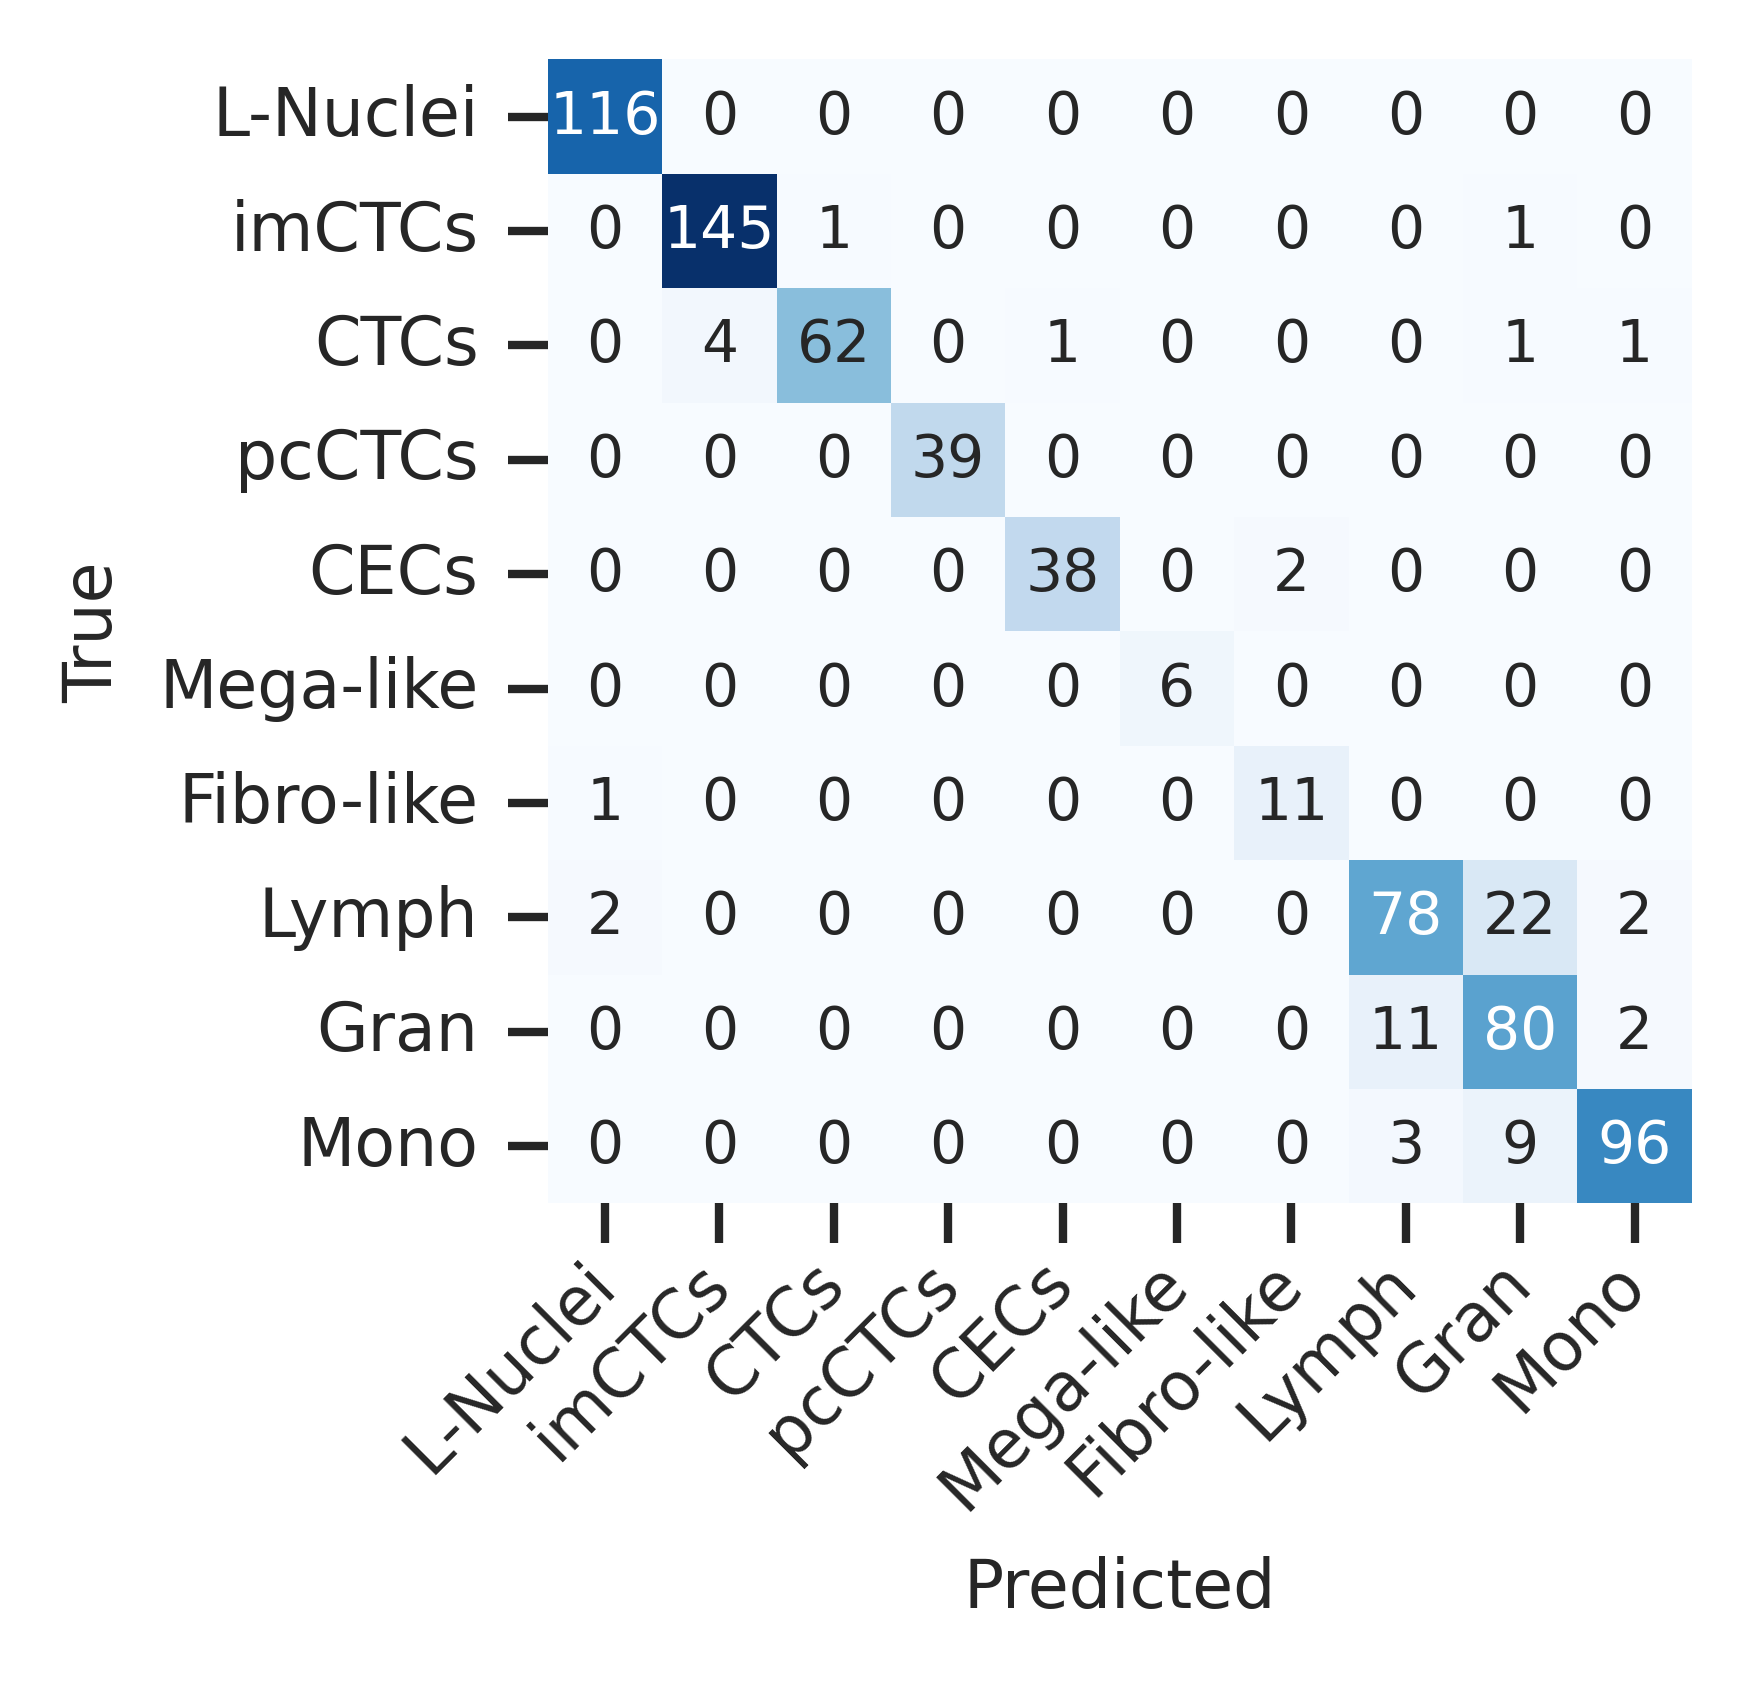

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(test_labels, y_pred)

fig, ax = plt.subplots(figsize=(3, 3), dpi=600)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=new_classes.values(),
    yticklabels=new_classes.values(),
    cbar=False,
    annot_kws={"size": 7},
    ax=ax
)

ax.set_xlabel("Predicted", fontsize=8)
ax.set_ylabel("True", fontsize=8)

ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=8,
    rotation=45,
    ha="right",
    va="center",
    rotation_mode="anchor"
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

ax.set_aspect("equal")     # keep square cells
plt.tight_layout()

fig.savefig(
    "/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/eng_figure2/trad_confusion_matrix.pdf",
    bbox_inches="tight"
)
plt.show()
plt.close(fig)


L-Nuclei 0.9940976571180136
imCTCs 0.9960483174083729
CTCs 0.9887464712689702
pcCTCs 1.0
CECs 0.9987652439024391
Mega-like 1.0
Fibro-like 0.9209581772784022
Lymph 0.8744244908019739
Gran 0.7943088212314176
Mono 0.9572244025032832


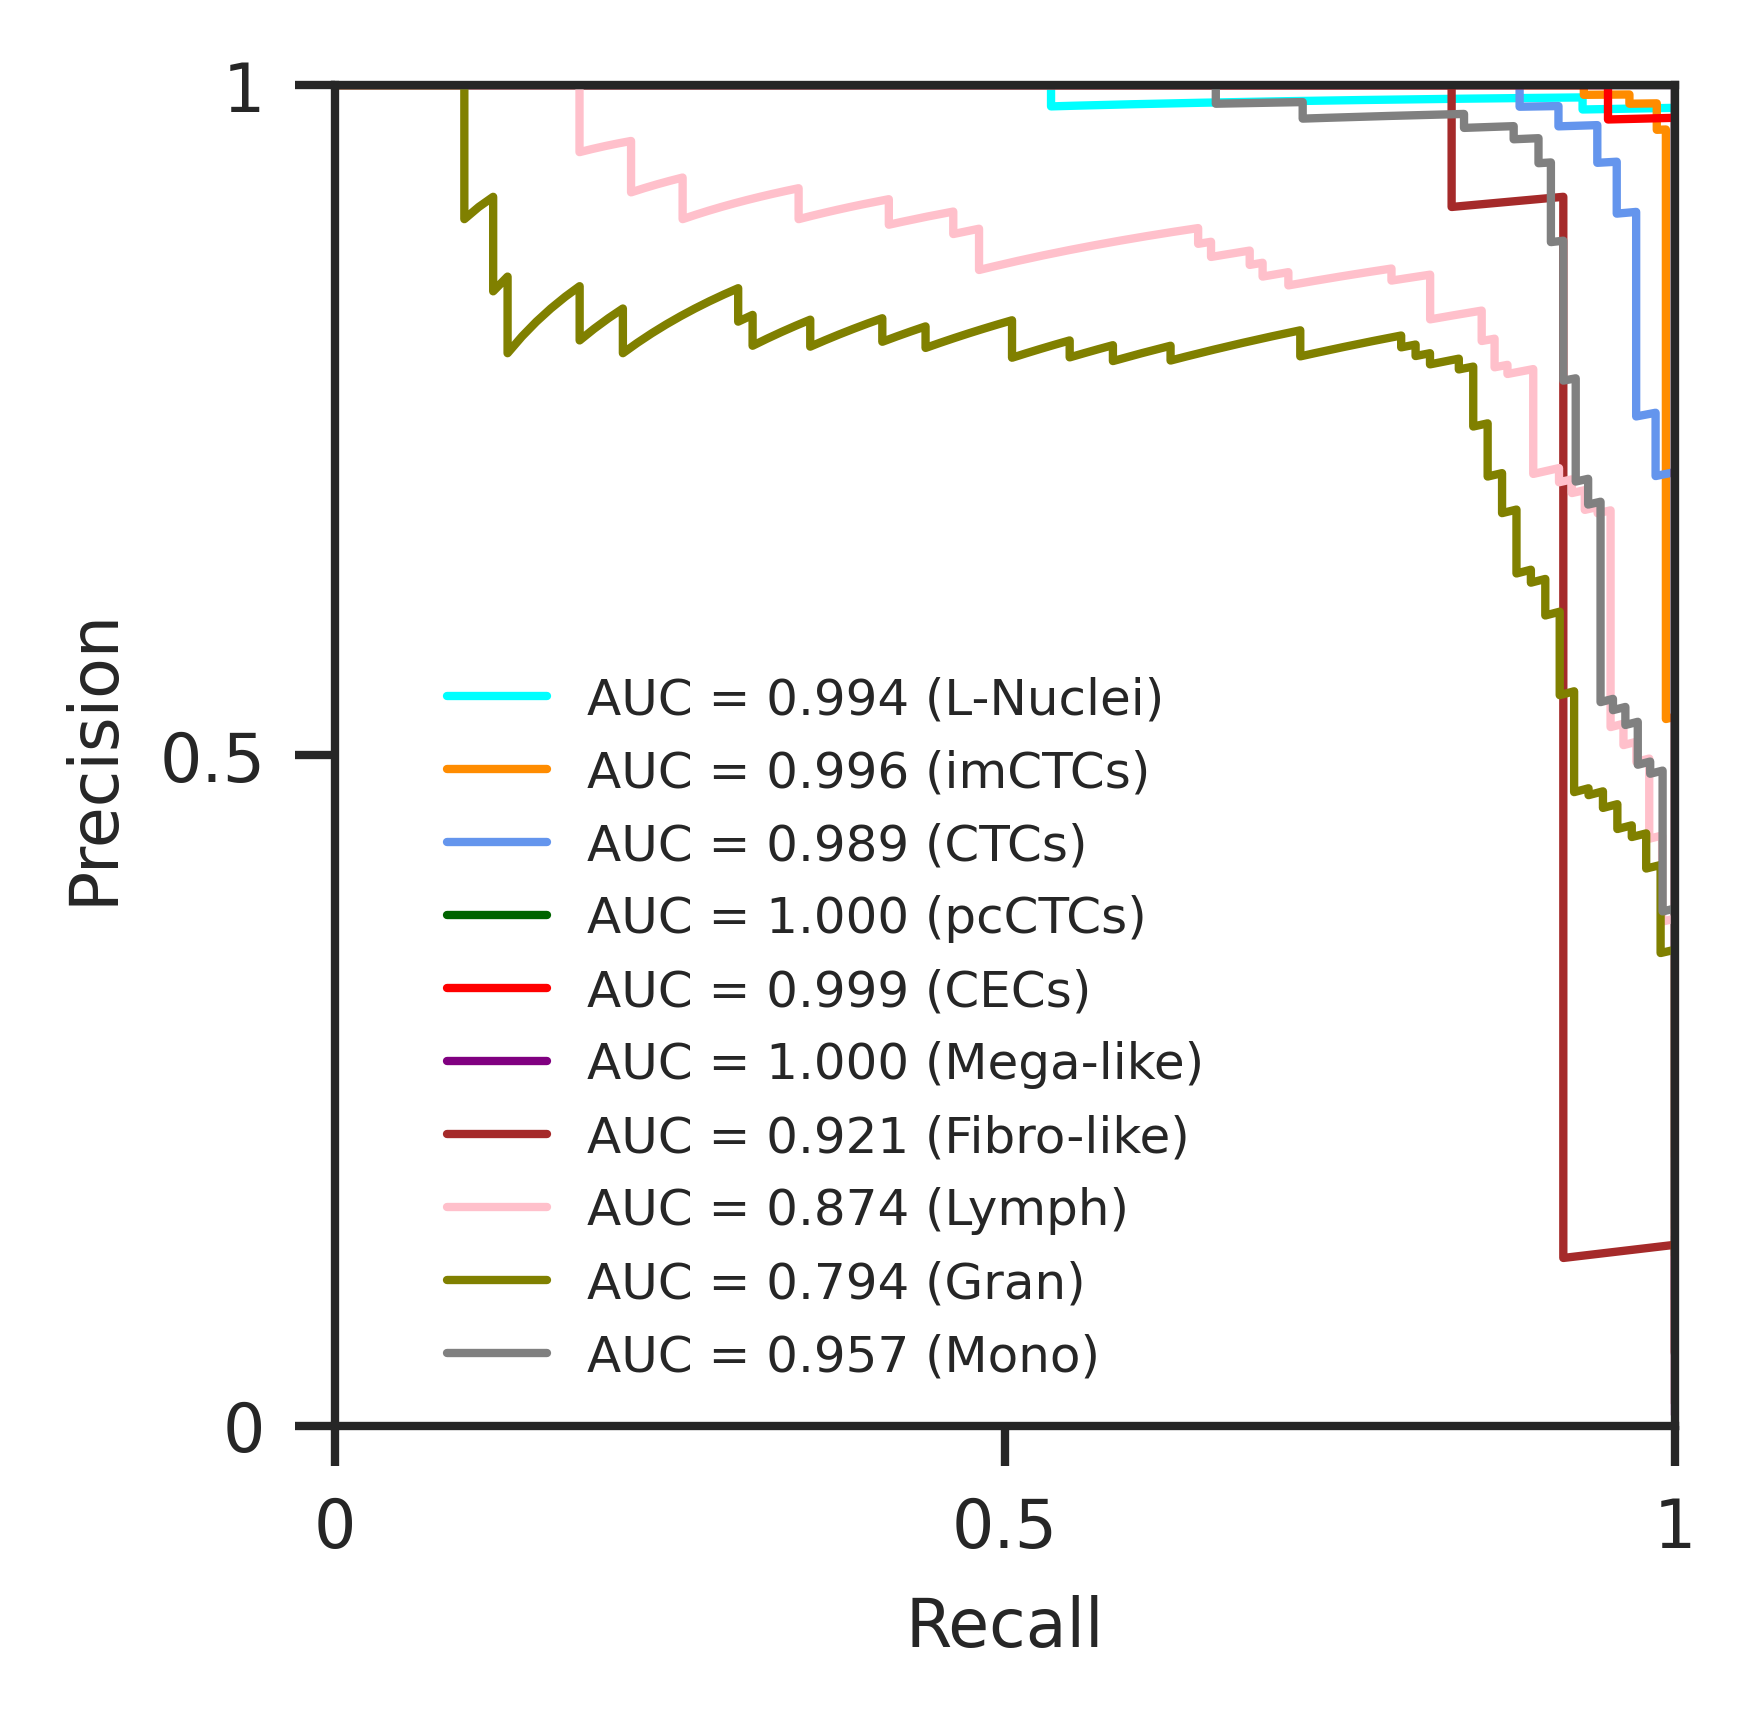

In [73]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming 'test_labels', 'test_cl', and your classifier 'clf' are defined,
# and classes is defined as in your snippet

# Binarize the test labels based on your classes
y_test_binarized = label_binarize(test_labels, classes=list(new_classes.keys()))
n_classes = len(new_classes)

# Get the prediction probabilities from your classifier
y_scores = clf.predict_proba(test_x)

plt.figure(figsize=(3, 3), dpi=600)

for i, class_index in enumerate(new_classes):
    class_name = new_classes[class_index]  # Get the class name
    # Calculate precision and recall for the current class
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
    # Calculate the average precision score for the current class
    ap = average_precision_score(y_test_binarized[:, i], y_scores[:, i])
    # Use the colors_dict to assign the color based on the class name
    plt.plot(recall, precision, lw=1, label=f'AUC = {ap:.3f} ({class_name})',  # Add AUC to the label
             alpha=1, color=colors_dict[class_name])
    print(class_name, ap)

plt.legend(frameon=False, markerscale=2, loc='lower left', fontsize=6, bbox_to_anchor=(0.05, 0))
plt.xticks([0, 0.5, 1], ['0', '0.5', '1'])
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'])
plt.xlim(0, 1)
plt.ylim(0, 1)
#set font size to 8
plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/eng_figure2/precision_recall_curve.pdf', bbox_inches='tight', dpi=600)
plt.show()


In [75]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# one‑vs‑rest binarisation
y_test_bin = label_binarize(test_labels, classes=list(new_classes.keys()))
n_classes  = y_test_bin.shape[1]

# class‑probability estimates
y_scores = clf.predict_proba(test_x)

# ── micro averages ─────────────────────────────────────────────
micro_roc_auc = roc_auc_score(y_test_bin, y_scores,
                              average='micro', multi_class='ovr')
micro_pr_auc  = average_precision_score(y_test_bin, y_scores,
                                        average='micro')

print(f"micro ROC‑AUC : {micro_roc_auc:.4f}")
print(f"micro PR‑AUC  : {micro_pr_auc:.4f}")

# ── macro averages (unweighted mean of classwise metrics) ──────
macro_roc_auc = roc_auc_score(y_test_bin, y_scores,
                              average='macro', multi_class='ovr')
macro_pr_auc  = average_precision_score(y_test_bin, y_scores,
                                        average='macro')

print(f"macro ROC‑AUC : {macro_roc_auc:.4f}")
print(f"macro PR‑AUC  : {macro_pr_auc:.4f}")


micro ROC‑AUC : 0.9955
micro PR‑AUC  : 0.9687
macro ROC‑AUC : 0.9921
macro PR‑AUC  : 0.9525
